# MAML reimplementation using PyTorch

Reproduction of MAML using PyTorch

This  is highly influenced by the Tensorflow reproduction by Mari Linhares: [Reproduction of MAML using TensorFlow 2.0.](https://colab.research.google.com/github/mari-linhares/tensorflow-maml/blob/master/maml.ipynb)

Github: [https://github.com/mari-linhares/tensorflow-maml](https://github.com/mari-linhares/tensorflow-maml)

Twitter: [@hereismari](https://twitter.com/hereismari)

## MAML paper

https://arxiv.org/abs/1703.03400

**Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks**
*Chelsea Finn, Pieter Abbeel, Sergey Levine*

> We propose an algorithm for meta-learning that is model-agnostic, in the sense that it is compatible with any model trained with gradient descent and applicable to a variety of different learning problems, including classification, regression, and reinforcement learning. The goal of meta-learning is to train a model on a variety of learning tasks, such that it can solve new learning tasks using only a small number of training samples. In our approach, the parameters of the model are explicitly trained such that a small number of gradient steps with a small amount of training data from a new task will produce good generalization performance on that task. In effect, our method trains the model to be easy to fine-tune. We demonstrate that this approach leads to state-of-the-art performance on two few-shot image classification benchmarks, produces good results on few-shot regression, and accelerates fine-tuning for policy gradient reinforcement learning with neural network policies.

---

![image.png](https://cdn-images-1.medium.com/max/1600/1*EUt0H5AOEFkERg-OzfCC7A.png)


### Imports

In [1]:
import torch

# Other dependencies
import random
import sys
import time

import numpy as np
import matplotlib.pyplot as plt


# Reproduction
random.seed(333)
np.random.seed(333)

print('Python version: ', sys.version)
print('PyTorch version: ', torch.__version__)

device_name = torch.cuda.get_device_name(0)
print('GPU found: {}'.format(device_name))

Python version:  3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
PyTorch version:  1.4.0
GPU found: Tesla P4


## Section 5.1 Evaluating MAML on regression

> We start with a simple regression problem that illustrates the basic principles of MAML. Each task involves regressing from the input to the output of a sine wave, where the amplitude and phase of the sinusoid are varied between tasks. Thus, p(T ) is continuous, where the amplitude varies within [0.1, 5.0] and the phase varies within [0, π], and the input and output both have a dimensionality of 1. During training and testing, datapoints x are sampled uniformly from [−5.0, 5.0].



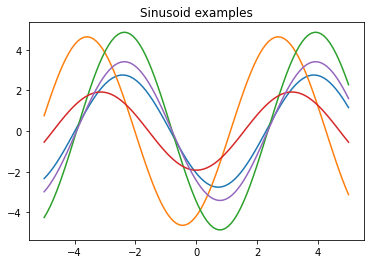

In [2]:
class SinusoidGenerator():
    '''
        Sinusoid Generator.
        
        p(T) is continuous, where the amplitude varies within [0.1, 5.0]
        and the phase varies within [0, π].
        
        This abstraction is the basically the same defined at:
        https://towardsdatascience.com/paper-repro-deep-metalearning-using-maml-and-reptile-fd1df1cc81b0  
    '''
    def __init__(self, K=10, amplitude=None, phase=None):
        '''
        Args:
            K: batch size. Number of values sampled at every batch.
            amplitude: Sine wave amplitude. If None is uniformly sampled from
                the [0.1, 5.0] interval.
            phase: Sine wave phase. If None is uniformly sampled from the [0, π]
                interval.
        '''
        self.K = K
        self.amplitude = amplitude if amplitude else np.random.uniform(0.1, 5.0)
        self.phase = phase if phase or phase == 0 else np.random.uniform(0, np.pi)
        self.sampled_points = None
        self.x = self._sample_x()
        
    def _sample_x(self):
        return np.random.uniform(-5, 5, self.K)
    
    def f(self, x):
        '''Sinewave function.'''
        return self.amplitude * np.sin(x - self.phase)

    def batch(self, x = None, force_new=False):
        '''Returns a batch of size K.
        
        It also changes the shape of `x` to add a batch dimension to it.
        
        Args:
            x: Batch data, if given `x` is generated based on this data.
                Usually it is None. If None `self.x` is used.
            force_new: Instead of using `x` argument the batch data is
                uniformly sampled.
        
        '''
        if x is None:
            if force_new:
                x = self._sample_x()
            else:
                x = self.x
        y = self.f(x)
        return x[:, None], y[:, None]
    
    def equally_spaced_samples(self, K=None):
        '''Returns `K` equally spaced samples.'''
        if K is None:
            K = self.K
        return self.batch(x=np.linspace(-5, 5, K))
        
        
def plot(data, *args, **kwargs):
    '''Plot helper.'''
    x, y = data
    return plt.plot(x, y, *args, **kwargs)


for _ in range(5):
    plt.title('Sinusoid examples')
    plot(SinusoidGenerator(K=100).equally_spaced_samples())
plt.show()

### Generate sinusoid datasets

In [0]:
def generate_dataset(K, train_size=20000, test_size=10):
    '''Generate train and test dataset.
    
    A dataset is composed of SinusoidGenerators that are able to provide
    a batch (`K`) elements at a time.
    '''
    def _generate_dataset(size):
        return [SinusoidGenerator(K=K) for _ in range(size)]
    return _generate_dataset(train_size), _generate_dataset(test_size) 

train_ds, test_ds = generate_dataset(K=10)

### Training a regular Neural Network

We're training a Neural Network for given a batch of size *K* of randomly sampled values (*x*) predict *f(x)* where f is a sine wave function with amplitude randomly sampled within [0.1, 5.0] and the phase randomly sampled within [0, π].

#### Model definition


> *The regressor
is a neural network model with 2 hidden layers of size
40 with ReLU nonlinearities.*

In [0]:
import torch.nn as nn
from torch.autograd import Variable as V
import torch.nn.functional as F

class ModifiableModule(nn.Module):
    def params(self):
        return [p for _, p in self.named_params()]
    
    def named_leaves(self):
        return []
    
    def named_submodules(self):
        return []
    
    def named_params(self):
        subparams = []
        for name, mod in self.named_submodules():
            for subname, param in mod.named_params():
                subparams.append((name + '.' + subname, param))
        return self.named_leaves() + subparams
    
    def set_param(self, name, param):
        if '.' in name:
            n = name.split('.')
            module_name = n[0]
            rest = '.'.join(n[1:])
            for name, mod in self.named_submodules():
                if module_name == name:
                    mod.set_param(rest, param)
                    break
        else:
            setattr(self, name, param)
            
    def copy(self, other, same_var=False):
        for name, param in other.named_params():
            if not same_var:
                param = V(param.data.clone(), requires_grad=True)
            self.set_param(name, param)

class GradLinear(ModifiableModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        ignore = nn.Linear(*args, **kwargs)
        self.weights = V(ignore.weight.data, requires_grad=True)
        self.bias = V(ignore.bias.data, requires_grad=True)
        
    def forward(self, x):
        return F.linear(x, self.weights, self.bias)
    
    def named_leaves(self):
        return [('weights', self.weights), ('bias', self.bias)]

class SineModel(ModifiableModule):
    def __init__(self):
        super().__init__()

        self.hidden1 = GradLinear(1, 40)
        self.hidden2 = GradLinear(40, 40)
        self.out = GradLinear(40, 1)
        
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        return self.out(x)
    
    def named_submodules(self):
        return [('hidden1', self.hidden1), ('hidden2', self.hidden2), ('out', self.out)]

#### Training implementation

In [0]:
def loss_function(pred_y, y):
  loss = torch.nn.MSELoss()
  return loss(pred_y, y)

def np_to_tensor(list_of_numpy_objs):
    return (torch.FloatTensor(obj) for obj in list_of_numpy_objs)


def compute_loss(model, x, y, loss_fn=loss_function):
    logits = model.forward(x)
    mse = loss_fn(logits, y)
    return mse, logits


def compute_gradients(model, x, y, loss_fn=loss_function):
    loss, _ = compute_loss(model, x, y, loss_fn)
    # create_graph = True is for non-first-order
    loss.backward(create_graph=True, retain_graph=True)
    return x.grad, loss # FIX: x.grad = None

    
def train_batch(x, y, model, optimizer):
    tensor_x, tensor_y = np_to_tensor((x, y))
    gradients, loss = compute_gradients(model, tensor_x, tensor_y)
    optimizer.step()
    optimizer.zero_grad()
    return loss


def train_model(dataset, epochs=1, lr=0.001, log_steps=1000):
    model = SineModel()
    optimizer = torch.optim.Adam(model.params(), lr=lr)
    for epoch in range(epochs):
        losses = []
        total_loss = 0
        start = time.time()
        for i, sinusoid_generator in enumerate(dataset):
            x, y = sinusoid_generator.batch()
            loss = train_batch(x, y, model, optimizer)
            total_loss += loss
            # normalize loss
            curr_loss = total_loss / (i + 1.0)
            losses.append(curr_loss)
            
            if i % log_steps == 0 and i > 0:
                print('Step {}: loss = {}, Time to run {} steps = {:.2f} seconds'.format(
                    i, curr_loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.title('Loss Vs Time steps')
        plt.show()
    return model

Step 1000: loss = 3.476447343826294, Time to run 1000 steps = 1.31 seconds
Step 2000: loss = 3.431459426879883, Time to run 1000 steps = 0.97 seconds
Step 3000: loss = 3.3161308765411377, Time to run 1000 steps = 0.99 seconds
Step 4000: loss = 3.240255832672119, Time to run 1000 steps = 0.97 seconds
Step 5000: loss = 3.217599391937256, Time to run 1000 steps = 0.97 seconds
Step 6000: loss = 3.1894190311431885, Time to run 1000 steps = 0.98 seconds
Step 7000: loss = 3.164618492126465, Time to run 1000 steps = 0.98 seconds
Step 8000: loss = 3.148622989654541, Time to run 1000 steps = 0.99 seconds
Step 9000: loss = 3.1290886402130127, Time to run 1000 steps = 0.98 seconds
Step 10000: loss = 3.1161396503448486, Time to run 1000 steps = 0.98 seconds
Step 11000: loss = 3.118356466293335, Time to run 1000 steps = 0.98 seconds
Step 12000: loss = 3.115715265274048, Time to run 1000 steps = 1.00 seconds
Step 13000: loss = 3.1160364151000977, Time to run 1000 steps = 1.00 seconds
Step 14000: loss

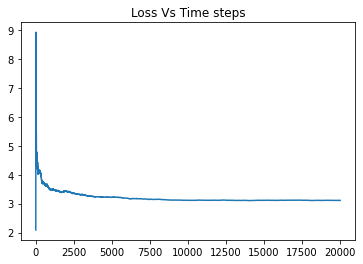

In [6]:
neural_net = train_model(train_ds)

In [0]:
def plot_model_comparison_to_average(model, ds, model_name='neural network', K=10):
    '''Compare model to average.
    
    Computes mean of training sine waves actual `y` and compare to
    the model's prediction to a new sine wave, the intuition is that
    these two plots should be similar.
    '''
    sinu_generator = SinusoidGenerator(K=K)
    
    # calculate average prediction
    avg_pred = []
    for i, sinusoid_generator in enumerate(ds):
        x, y = sinusoid_generator.equally_spaced_samples()
        avg_pred.append(y)
    
    x, _ = sinu_generator.equally_spaced_samples()    
    avg_plot, = plt.plot(x, np.mean(avg_pred, axis=0), '--')

    # calculate model prediction
    model_pred = model.forward(torch.FloatTensor(x))
    model_plot, = plt.plot(x, model_pred.data.numpy())
    
    # plot
    plt.legend([avg_plot, model_plot], ['Average', model_name])
    plt.show()

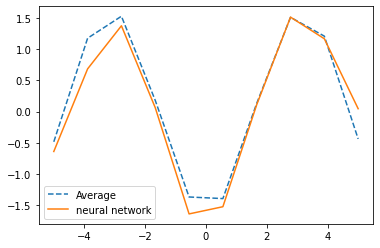

In [8]:
plot_model_comparison_to_average(neural_net, train_ds)

In [0]:
def copy_model(model, same_var = False):
    '''Copy model weights to a new model.
    
    Args:
        model: model to be copied.
        x: An input example. This is used to run
            a forward pass in order to add the weights of the graph
            as variables.
    Returns:
        A copy of the model.
    '''
    copied_model = SineModel()
    copied_model.copy(model, same_var = same_var)
    return copied_model


def eval_sine_test(model, optimizer, x, y, x_test, y_test, num_steps=(0, 1, 10)):
    '''Evaluate how the model fits to the curve training for `fits` steps.
    
    Args:
        model: Model evaluated.
        optimizer: Optimizer to be for training.
        x: Data used for training.
        y: Targets used for training.
        x_test: Data used for evaluation.
        y_test: Targets used for evaluation.
        num_steps: Number of steps to log.
    '''
    fit_res = []
    
    tensor_x_test, tensor_y_test = np_to_tensor((x_test, y_test))
    
    # If 0 in fits we log the loss before any training
    if 0 in num_steps:
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        fit_res.append((0, logits, loss))
        
    for step in range(1, np.max(num_steps) + 1):
        train_batch(x, y, model, optimizer)
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        if step in num_steps:
            fit_res.append(
                (
                    step, 
                    logits,
                    loss
                )
            )
    return fit_res


def eval_sinewave_for_test(model, sinusoid_generator=None, num_steps=(0, 1, 10), lr=0.01, plot=True):
    '''Evaluates how the sinewave addapts at dataset.
    
    The idea is to use the pretrained model as a weight initializer and
    try to fit the model on this new dataset.
    
    Args:
        model: Already trained model.
        sinusoid_generator: A sinusoidGenerator instance.
        num_steps: Number of training steps to be logged.
        lr: Learning rate used for training on the test data.
        plot: If plot is True than it plots how the curves are fitted along
            `num_steps`.
    
    Returns:
        The fit results. A list containing the loss, logits and step. For
        every step at `num_steps`.
    '''
    
    if sinusoid_generator is None:
        sinusoid_generator = SinusoidGenerator(K=10)
        
    # generate equally spaced samples for ploting
    x_test, y_test = sinusoid_generator.equally_spaced_samples(100)
    
    # batch used for training
    x, y = sinusoid_generator.batch()
    
    # copy model so we can use the same model multiple times
    copied_model = copy_model(model)
    
    # use SGD for this part of training as described in the paper
    optimizer = torch.optim.SGD(copied_model.params(), lr=lr)
    
    # run training and log fit results
    fit_res = eval_sine_test(copied_model, optimizer, x, y, x_test, y_test, num_steps)
    
    # plot
    train, = plt.plot(x, y, '^')
    ground_truth, = plt.plot(x_test, y_test)
    plots = [train, ground_truth]
    legend = ['Training Points', 'True Function']
    for n, res, loss in fit_res:
        cur, = plt.plot(x_test, res[:, 0].data, '--')
        plots.append(cur)
        legend.append(f'After {n} Steps')
    plt.legend(plots, legend)
    plt.ylim(-5, 5)
    plt.xlim(-6, 6)
    if plot:
        plt.show()
    
    return fit_res

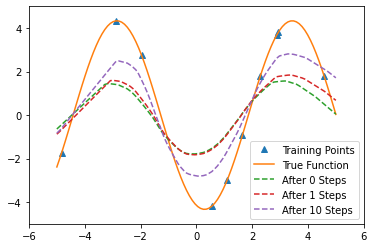

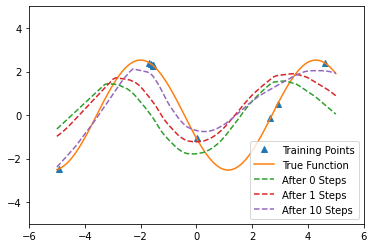

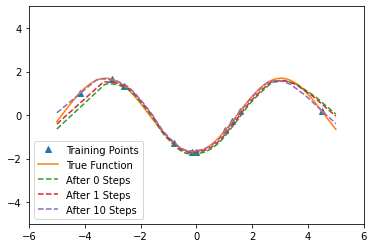

In [10]:
for index in np.random.randint(0, len(test_ds), size=3):
    eval_sinewave_for_test(neural_net, test_ds[index])

### MAML

![](https://cdn-images-1.medium.com/max/1600/1*_pgbRGIlmCRsYNBHl71mUA.png)

In [0]:
def train_maml(model, epochs, dataset, lr_inner=0.01, batch_size=1, log_steps=1000):
    '''Train using the MAML setup.
    
    The comments in this function that start with:
        
        Step X:
        
    Refer to a step described in the Algorithm 1 of the paper.
    
    Args:
        model: A model.
        epochs: Number of epochs used for training.
        dataset: A dataset used for training.
        lr_inner: Inner learning rate (alpha in Algorithm 1). Default value is 0.01.
        batch_size: Batch size. Default value is 1. The paper does not specify
            which value they use.
        log_steps: At every `log_steps` a log message is printed.
    
    Returns:
        A strong, fully-developed and trained maml.
    '''
    optimizer = torch.optim.Adam(model.params())

    # Step 2: instead of checking for convergence, we train for a number
    # of epochs
    for _ in range(epochs):
        total_loss = 0
        losses = []
        start = time.time()
        # Step 3 and 4
        for i, t in enumerate(random.sample(dataset, len(dataset))):
            # Step 3
            x, y = np_to_tensor(t.batch())
            model_copy = copy_model(model, same_var = True)
            # Step 5
            _, train_loss = compute_gradients(model_copy, x, y) # loss + backward
            # Step 6
            for name, param in model_copy.named_params():
                grad = param.grad
                model_copy.set_param(name, param - lr_inner * grad)
            #model.zero_grad()
            # Step 8
            x, y = np_to_tensor(t.batch(force_new=True))
            _, test_loss = compute_gradients(model_copy, x, y)
            if (i + 1) % batch_size == 0:
                optimizer.step()
                optimizer.zero_grad()

            # Logs
            total_loss += test_loss
            loss = total_loss / (i+1.0)
            losses.append(loss)
            
            if i % log_steps == 0 and i > 0:
                print('Step {}: loss = {}, Time to run {} steps = {}s'.format(i, loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.show()

Step 1000: loss = 3.2065536975860596, Time to run 1000 steps = 2.9431204795837402s
Step 2000: loss = 2.9026498794555664, Time to run 1000 steps = 2.9054131507873535s
Step 3000: loss = 2.64013671875, Time to run 1000 steps = 2.8875269889831543s
Step 4000: loss = 2.462841272354126, Time to run 1000 steps = 2.882617473602295s
Step 5000: loss = 2.3577892780303955, Time to run 1000 steps = 2.9336304664611816s
Step 6000: loss = 2.272296905517578, Time to run 1000 steps = 2.9527511596679688s
Step 7000: loss = 2.1991119384765625, Time to run 1000 steps = 2.9221346378326416s
Step 8000: loss = 2.131016969680786, Time to run 1000 steps = 2.891890525817871s
Step 9000: loss = 2.0622737407684326, Time to run 1000 steps = 2.8711049556732178s
Step 10000: loss = 2.0038998126983643, Time to run 1000 steps = 2.8585898876190186s
Step 11000: loss = 1.9376001358032227, Time to run 1000 steps = 2.8287744522094727s
Step 12000: loss = 1.8804435729980469, Time to run 1000 steps = 2.8415238857269287s
Step 13000:

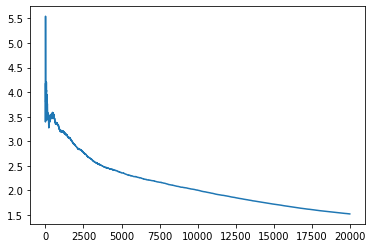

In [23]:
maml = SineModel()
train_maml(maml, 1, train_ds)

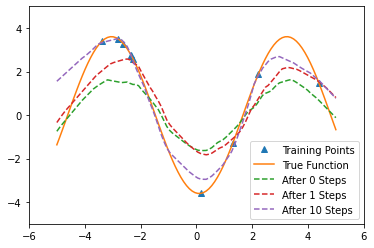

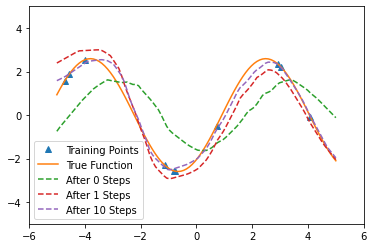

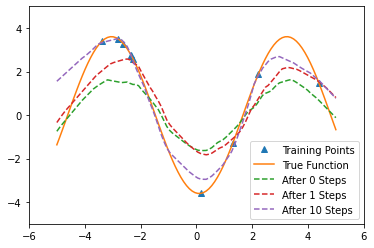

In [24]:
for index in np.random.randint(0, len(test_ds), size=3):
    eval_sinewave_for_test(maml, test_ds[index])

In [0]:
def compare_maml_and_neural_net(maml, neural_net, sinusoid_generator, num_steps=list(range(10)),
                                intermediate_plot=True, marker='x', linestyle='--'):
    '''Compare the loss of a MAML model and a neural net.
    
    Fits the models for a new task (new sine wave) and then plot
    the loss of both models along `num_steps` interactions.
    
    Args:
        maml: An already trained MAML.
        neural_net: An already trained neural net.
        num_steps: Number of steps to be logged.
        intermediate_plot: If True plots intermediate plots from
            `eval_sinewave_for_test`.
        marker: Marker used for plotting.
        linestyle: Line style used for plotting.
    '''
    if intermediate_plot:
        print('MAML')
    fit_maml = eval_sinewave_for_test(maml, sinusoid_generator, plot=intermediate_plot)
    if intermediate_plot:
        print('Neural Net')
    fit_neural_net = eval_sinewave_for_test(neural_net, sinusoid_generator, plot=intermediate_plot)
    
    fit_res = {'MAML': fit_maml, 'Neural Net': fit_neural_net}
    
    legend = []
    for name in fit_res:
        x = []
        y = []
        for n, _, loss in fit_res[name]:
            x.append(n)
            y.append(loss)
        plt.plot(x, y, marker=marker, linestyle=linestyle)
        plt.xticks(num_steps)
        legend.append(name)
    plt.legend(legend)
    plt.show()

MAML


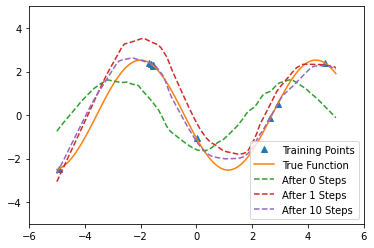

Neural Net


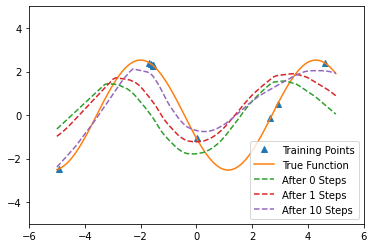

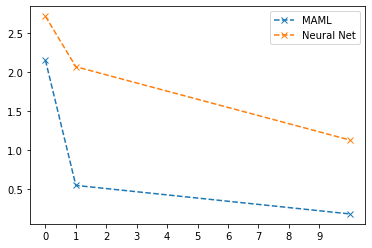

MAML


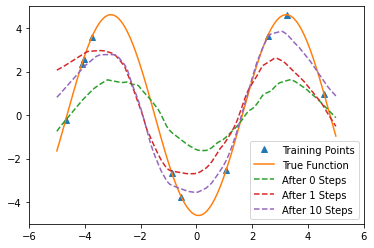

Neural Net


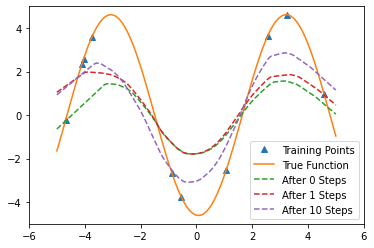

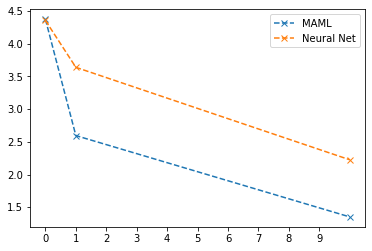

MAML


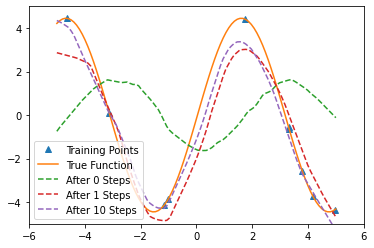

Neural Net


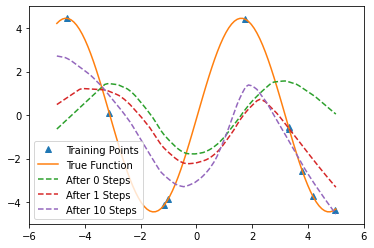

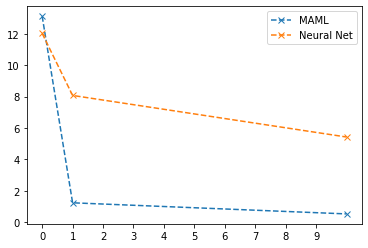

In [26]:
for _ in range(3):
    index = np.random.choice(range(len(test_ds)))
    compare_maml_and_neural_net(maml, neural_net, test_ds[index])

### Reptile

![](https://miro.medium.com/max/468/1*WmG_R90SyXjWwu6qPfwtQQ.png)

In [0]:
def train_reptile(model, epochs, dataset, lr_inner=0.01, lr_outer = 0.001, batch_size=32, k = 32, log_steps=1000):
    '''Train using the Reptile setup.
    
    The comments in this function that start with:
        
        Step X:
        
    Refer to a step described in the Algorithm 1 of the paper.
    
    Args:
        model: A model.
        epochs: Number of epochs used for training.
        dataset: A dataset used for training.
        lr_inner: Inner learning rate (alpha in Algorithm 1). Default value is 0.01.
        batch_size: Batch size. Default value is 1. The paper does not specify
            which value they use.
        log_steps: At every `log_steps` a log message is printed.
    
    Returns:
        A strong, fully-developed and trained maml.
    '''
    optimizer = torch.optim.Adam(model.params(), lr= lr_outer)
    name_to_param = dict(model.named_params())
    

    # Step 2: instead of checking for convergence, we train for a number
    # of epochs
    for _ in range(epochs):
        total_loss = 0
        losses = []
        start = time.time()
        # Step 3 and 4
        for i, t in enumerate(random.sample(dataset, len(dataset))):
            # Step 3
            x, y = np_to_tensor(t.batch())
            model_copy = copy_model(model)
            inner_optim = torch.optim.SGD(model_copy.params(), lr=lr_inner)
            # Step 5
            for _ in range(k):
                train_batch(x, y, model_copy, inner_optim)
            # Step 6
            for name, param in model_copy.named_params():
                cur_grad = (name_to_param[name].data - param.data) / k / lr_inner
                if name_to_param[name].grad is None:
                    name_to_param[name].grad = V(torch.zeros(cur_grad.size()))
                name_to_param[name].grad.data.add_(cur_grad / batch_size)
            # Step 8
            if (i + 1) % batch_size == 0:
                optimizer.step()
                optimizer.zero_grad()
            after_train_loss, _ = compute_loss(model, x, y)

            # Logs
            total_loss += after_train_loss
            loss = total_loss / (i+1.0)
            losses.append(loss)
            
            if i % log_steps == 0 and i > 0:
                print('Step {}: loss = {}, Time to run {} steps = {}s'.format(i, loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.show()

Step 1000: loss = 3.535900354385376, Time to run 1000 steps = 3.204939842224121s
Step 2000: loss = 3.341198444366455, Time to run 1000 steps = 3.1693215370178223s
Step 3000: loss = 3.2506332397460938, Time to run 1000 steps = 3.1274020671844482s
Step 4000: loss = 3.222015142440796, Time to run 1000 steps = 3.2144641876220703s
Step 5000: loss = 3.1966521739959717, Time to run 1000 steps = 3.17090106010437s
Step 6000: loss = 3.1430013179779053, Time to run 1000 steps = 3.2344858646392822s
Step 7000: loss = 3.128566265106201, Time to run 1000 steps = 3.2483131885528564s
Step 8000: loss = 3.130727767944336, Time to run 1000 steps = 3.1737372875213623s
Step 9000: loss = 3.15531849861145, Time to run 1000 steps = 3.177065372467041s
Step 10000: loss = 3.1359341144561768, Time to run 1000 steps = 3.1883537769317627s
Step 11000: loss = 3.1375319957733154, Time to run 1000 steps = 3.225414752960205s
Step 12000: loss = 3.130891799926758, Time to run 1000 steps = 3.2070460319519043s
Step 13000: lo

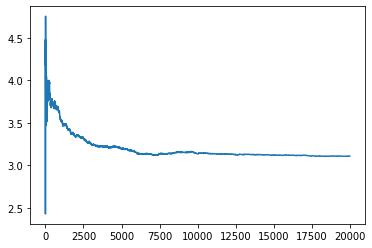

In [31]:
reptile = SineModel()
train_reptile(reptile, 1, train_ds, k=3, batch_size=1)

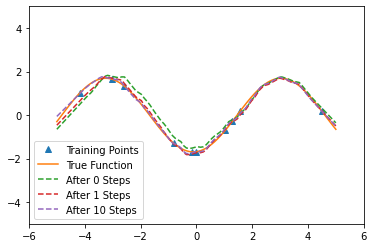

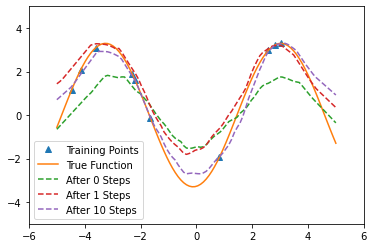

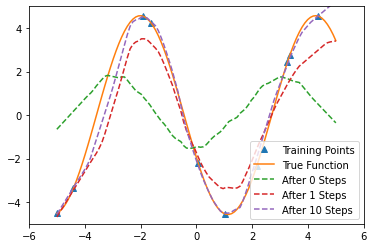

In [35]:
for index in np.random.randint(0, len(test_ds), size=3):
    eval_sinewave_for_test(reptile, test_ds[index])

In [0]:
def compare_maml_and_reptile(maml, reptile, sinusoid_generator, num_steps=list(range(10)),
                                intermediate_plot=True, marker='x', linestyle='--'):
    '''Compare the loss of a MAML model and a neural net.
    
    Fits the models for a new task (new sine wave) and then plot
    the loss of both models along `num_steps` interactions.
    
    Args:
        maml: An already trained MAML.
        neural_net: An already trained neural net.
        num_steps: Number of steps to be logged.
        intermediate_plot: If True plots intermediate plots from
            `eval_sinewave_for_test`.
        marker: Marker used for plotting.
        linestyle: Line style used for plotting.
    '''
    if intermediate_plot:
        print('MAML')
    fit_maml = eval_sinewave_for_test(maml, sinusoid_generator, plot=intermediate_plot)
    if intermediate_plot:
        print('Reptile')
    fit_reptile = eval_sinewave_for_test(reptile, sinusoid_generator, plot=intermediate_plot)
    
    fit_res = {'MAML': fit_maml, 'Reptile': fit_reptile}
    
    legend = []
    for name in fit_res:
        x = []
        y = []
        for n, _, loss in fit_res[name]:
            x.append(n)
            y.append(loss)
        plt.plot(x, y, marker=marker, linestyle=linestyle)
        plt.xticks(num_steps)
        legend.append(name)
    plt.legend(legend)
    plt.show()

MAML


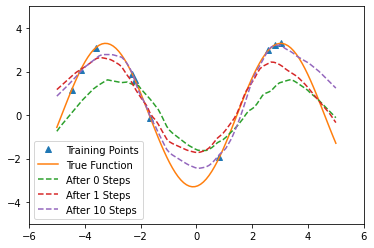

Reptile


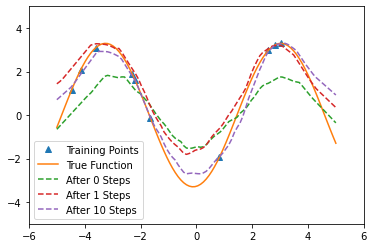

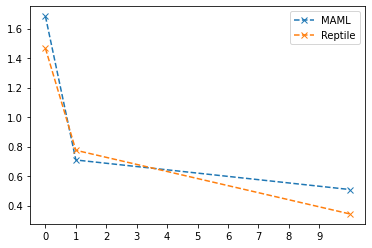

MAML


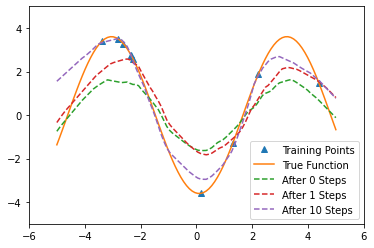

Reptile


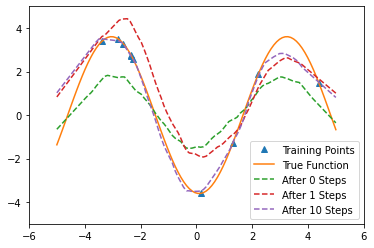

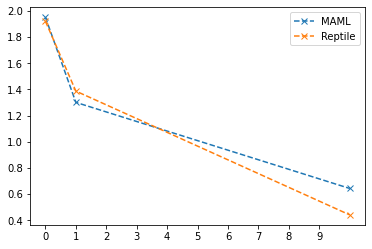

MAML


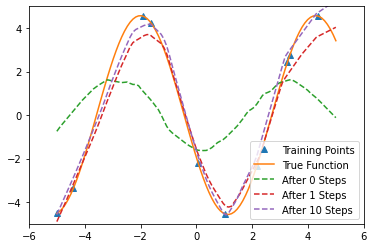

Reptile


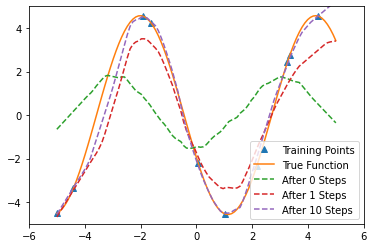

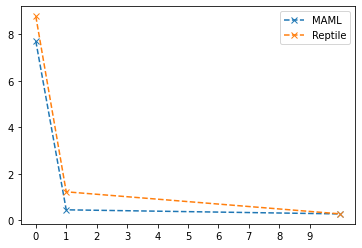

In [41]:
for _ in range(3):
    index = np.random.choice(range(len(test_ds)))
    compare_maml_and_reptile(maml, reptile, test_ds[index])